In [1]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

from event_clustering.preprocessing import *
from event_clustering.clustering import *
from event_clustering.postprocessing import *
from event_clustering.process_mining import *

from sklearn.cluster import *
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics
import sklearn.metrics.cluster as cluster_metrics

import scipy.cluster.hierarchy as sch

# Load Encoded Events

In [14]:
file_name = 'DomesticDeclarations'
df = preprocess(load('data/' + file_name + '.xes'))
df_encoded = pd.read_csv('data/' + file_name + '_name-role_encoded.csv')
original_df_columns = df.columns

# Clustering

### KMeans

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


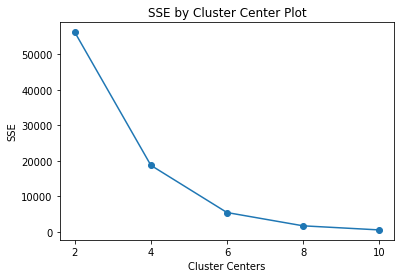

In [4]:
find_optimal_clusters(df_encoded, 10)

In [15]:
cluster_nr = 6
km = MiniBatchKMeans(n_clusters=cluster_nr, init_size=1024, batch_size=2048, random_state=20)
cluster_labels = km.fit_predict(df_encoded)

### Hierarchical Clustering

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
hier_dendogram = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage = "single").fit(df_encoded)

# Plot the corresponding dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
#plot_dendrogram(hier_dendogram, truncate_mode='level', p=5)
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(hier_dendogram, truncate_mode='level', p=40)
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

In [14]:
# --> determine amount of clusters
agg_clusters = 3
hier = AgglomerativeClustering(n_clusters=agg_clusters, linkage="single").fit(df_encoded)
cluster_labels = hier.labels_

## Evaluation

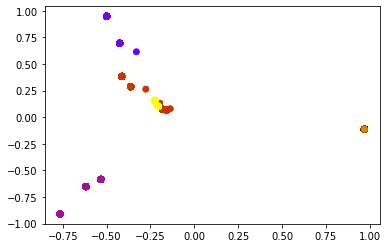

In [6]:
plot_pca(df_encoded, cluster_labels, cluster_nr)

In [7]:
print("Completeness KMeans: ", metrics.completeness_score(df['concept:name'], cluster_labels))
print("Silhouette Coefficient KMeans: ", metrics.silhouette_score(df_encoded, cluster_labels))

Completeness KMeans:  0.9999999999999994
Silhouette Coefficient KMeans:  0.9238737704290397


In [16]:
df['cluster_label'] = cluster_labels

## Check cluster labels "manually"

In [17]:
# group by cluster label and aggregate concept:name
eval_manually = df.groupby('cluster_label')['concept:name'].apply(set)

In [18]:
pd.set_option('display.max_colwidth', -1)
eval_manually

/home/larissa/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


cluster_label
0    {Request Payment}                                                                                                                                                                                                                                                                  
1    {Declaration REJECTED by SUPERVISOR, Declaration FINAL_APPROVED by SUPERVISOR, Declaration FOR_APPROVAL by SUPERVISOR}                                                                                                                                                             
2    {Declaration REJECTED by EMPLOYEE, Declaration SUBMITTED by EMPLOYEE, Declaration SAVED by EMPLOYEE}                                                                                                                                                                               
3    {Declaration APPROVED by ADMINISTRATION, Declaration APPROVED by PRE_APPROVER, Declaration REJECTED by PRE_APPROVER, Declaration REJECTED 

## Use Supervised Approach

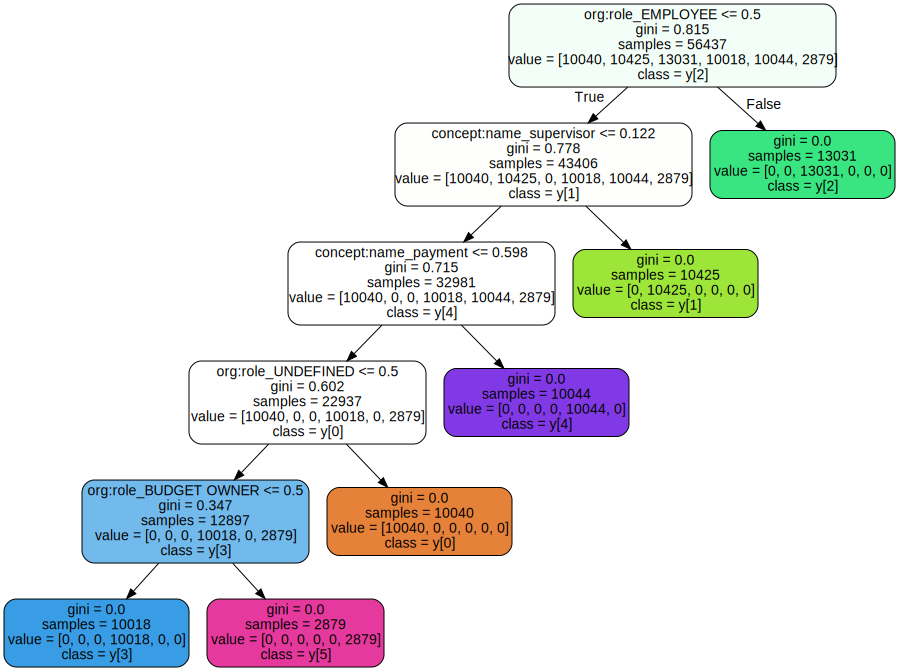

In [73]:
# encode the trained features again for supervised evaluation
df_name = tfidf_encode(df, 'concept:name', TfidfVectorizer(stop_words = 'english'))
df_role = one_hot_encode(df, 'org:role')

X = df_name.join(df_role)
Y = df["cluster_label"]

clf = tree.DecisionTreeClassifier()
clf1 = clf.fit(X,Y)

dot_data = tree.export_graphviz(clf1, out_file=None, feature_names=X.columns, class_names=True, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
#graph.render("data/domesticDeclarations")
graph

In [118]:
# split into test and training data set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [119]:
SVM_model = svm.SVC()
SVM_pred = SVM_model.fit(x_train, y_train).predict(x_test)

tree_model = tree.DecisionTreeClassifier()
tree_pred = tree_model.fit(x_train, y_train).predict(x_test)

KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_pred = KNN_model.fit(x_train, y_train).predict(x_test)

log_model = LogisticRegression()
log_pred = log_model.fit(x_train, y_train).predict(x_test)

gauss_model = GaussianNB()
gauss_pred = gauss_model.fit(x_train, y_train).predict(x_test)

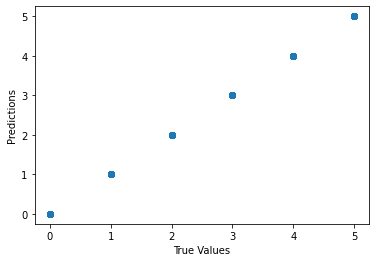

In [120]:
# plot predictions against the true values
plt.scatter(y_test, gauss_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [126]:
print("SVM Classifier: ", accuracy_score(SVM_pred, y_test))
print("KNN Classifier: ", accuracy_score(KNN_pred, y_test))
print("Decision Tree Classifier: ", accuracy_score(tree_pred, y_test))
print("Logistic Regression Classifier: ", accuracy_score(log_pred, y_test))
print("Gaussian Naive Bayes Classifier: ", accuracy_score(gauss_pred, y_test))

SVM Classifier:  1.0
KNN Classifier:  1.0
Decision Tree Classifier:  0.9999114103472715
Logistic Regression Classifier:  1.0
Gaussian Naive Bayes Classifier:  1.0


In [ ]:
print("SVM Classifier: ", confusion_matrix(SVM_pred, y_test))
print("KNN Classifier: ", confusion_matrix(KNN_pred, y_test))
print("Decision Tree Classifier: ", confusion_matrix(tree_pred, y_test))
print("Logistic Regression Classifier: ", confusion_matrix(log_pred, y_test))
print("Gaussian Naive Bayes Classifier: ", confusion_matrix(gauss_pred, y_test))

In [ ]:
print("SVM Classifier: ", classification_report(SVM_pred, y_test))
print("KNN Classifier: ", classification_report(KNN_pred, y_test))
print("Decision Tree Classifier: ", classification_report(tree_pred, y_test))
print("Logistic Regression Classifier: ", classification_report(log_pred, y_test))
print("Gaussian Naive Bayes Classifier: ", classification_report(gauss_pred, y_test))

In [129]:
prediction = tree_pred
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != prediction).sum()))

Number of mislabeled points out of a total 11288 points : 1


## Replace events with cluster representative

In [12]:
# overwrite concept:name with mapped cluster representative
abstracted_df = replace_with_representative(df, "concept:name", "cluster_label", original_df_columns)
abstracted_df.head(5)

,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,C,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,C,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,C,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,C,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,B,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00


In [ ]:
# write abstracted dataframe as csv file
csv_filename = "data/abs_km_bpic15.csv"
write_to_csv(abstracted_df, csv_filename, index=False)

# Compare Process Models from Original Dataset to Abstracted Dataset

In [ ]:
# read original and abstracted dataset as event logs
filepath_original = "data/BPIC15_1.xes"
filepath_abstracted = csv_filename

original_log = read_as_log_xes(filepath_original)
abstracted_log = read_as_log_csv(filepath_abstracted)

print("Original Log:")
print(original_log)
print("\nAbstracted Log:")
print(abstracted_log)

## Mining Algorithms
* Alpha Miner
* Inductive Miner
* Heuristic Miner
* Directly-Follows Graph

In [ ]:
# Alpha Miner
net_alpha_orig, im_alpha_orig, fm_alpha_orig = a_miner(original_log)
net_alpha, im_alpha, fm_alpha = a_miner(abstracted_log)

In [ ]:
# Inductive Miner
net_ind_orig, im_ind_orig, fm_ind_orig = ind_miner(original_log)
net_ind, im_ind, fm_ind = ind_miner(abstracted_log)

In [ ]:
# Heuristic Miner
net_heu_orig, im_heu_orig, fm_heu_orig = heu_miner(original_log)
net_heu, im_heu, fm_heu = heu_miner(abstracted_log)

In [ ]:
# Directly-Follows Graph
dfg_miner(original_log)
dfg_miner(abstracted_log)

## Process Model Metrics
* Fitness
* Precision
* Generalization
* Simplicity

In [ ]:
# Evaluation --> all four metrices in one line
print("Original Log with Heuristic Miner:")
evaluation_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
evaluation_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
print("Original Log with Inductive Miner:")
evaluation_metric(original_log, net_ind_orig, im_ind_orig, fm_ind_orig )

print("\nAbstracted Log with Inductive Miner")
evaluation_metric(abstracted_log, net_ind, im_ind, fm_ind)

In [ ]:
# Fitness
print("Original Log with Heuristic Miner:")
fitness_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
fitness_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Precision
print("Original Log with Heuristic Miner:")
precision_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
precision_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Generalization
print("Original Log with Heuristic Miner:")
generalization_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
generalization_metric(abstracted_log, net_heu, im_heu, fm_heu)

In [ ]:
# Simplicity
print("Original Log with Heuristic Miner:")
simplicity_metric(original_log, net_heu_orig, im_heu_orig, fm_heu_orig)

print("\nAbstracted Log with Heuristic Miner")
simplicity_metric(abstracted_log, net_heu, im_heu, fm_heu)